In [177]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import datetime
import os
import random
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [179]:
train_path = "dataset/train/"
val_path = "dataset/valid/"

In [180]:
def take_image_dataset_from_directory(filepath, label_mode, img_size, batch_size, shuffle=False):
    img_dataset = tf.keras.preprocessing.image_dataset_from_directory(filepath,
                                                                      label_mode=label_mode,
                                                                      batch_size=batch_size,
                                                                      image_size=(img_size, img_size),
                                                                      shuffle=shuffle)

    return img_dataset

In [181]:
LABEL_MODE = "categorical"
IMG_SIZE = 128
BATCH_SIZE = 32

In [182]:
train_dataset = take_image_dataset_from_directory(filepath=train_path, 
                                                  label_mode=LABEL_MODE,
                                                  img_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True)

val_dataset = take_image_dataset_from_directory(filepath=val_path,
                                                label_mode=LABEL_MODE,
                                                img_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE)

Found 7946 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


In [183]:
class_names = train_dataset.class_names

In [184]:
class_names = np.array(class_names)
class_names

array(['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless',
       'American Spaniel', 'Basenji', 'Basset', 'Beagle',
       'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim',
       'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi',
       'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier',
       'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow',
       'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote',
       'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound',
       'French Bulldog', 'German Sheperd', 'Golden Retriever',
       'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael',
       'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor',
       'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese',
       'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull',
       'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler',
       'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei',
       'Shiba In

In [185]:
np.save("dog_breed_class_names.npy", class_names)

In [24]:
sample_img = []
sample_label = []

for i, data in enumerate(train_dataset.unbatch().as_numpy_iterator()):
    if i == 10:
        break
    else:
        img, label = data
        sample_img.append(img)
        sample_label.append(label)

In [29]:
def view_random_train_images(img, label):
    random_num = random.randint(0, len(img)-1)
    random_img = img[random_num]
    random_label = label[random_num]
    random_class = class_names[tf.argmax(random_label)]

    plt.imshow(random_img/255.)
    plt.title(random_class)
    plt.axis(False)

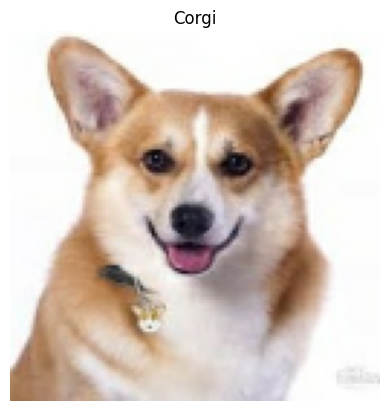

In [35]:
view_random_train_images(sample_img, sample_label)

In [36]:
train_dataset, val_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 70), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 70), dtype=tf.float32, name=None))>)

In [37]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [38]:
def img_augmentation_layer(img_size):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomHeight(0.2),
        tf.keras.layers.RandomWidth(0.2),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.Resizing(img_size, img_size)
    ], name="img_augmentation_layer")

In [39]:
img_augmentation = img_augmentation_layer(IMG_SIZE)

# Experiment 1 - Transfer Learning Feature Extraction

In [40]:
INPUT_SHAPE = (128, 128, 3)

In [152]:
base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False,
                                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

In [153]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 129, 129, 3)  0           ['normalization[0][0

In [154]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=INPUT_SHAPE, dtype=tf.float32)
aug_layer = img_augmentation(inputs)
b1_layer = base_model(aug_layer)
avg_layer = layers.GlobalAveragePooling2D()(b1_layer)
outputs = layers.Dense(len(class_names), activation="softmax")(avg_layer)

model = tf.keras.Model(inputs, outputs, name="b1_model")

In [155]:
model.summary()

Model: "b1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 img_augmentation_layer (Seq  (None, 128, 128, 3)      0         
 uential)                                                        
                                                                 
 efficientnetb1 (Functional)  (None, 4, 4, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 70)                89670     
                                                                 
Total params: 6,664,909
Trainable params: 89,670
Non-train

In [45]:
def tensorboard_cb(dirpath, model_name):
    return tf.keras.callbacks.TensorBoard(os.path.join(dirpath, 
                                                       model_name, 
                                                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

def checkpoint_cb(dirpath, model_name, save_format=None, save_weights=False):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(dirpath, model_name + save_format), 
                                              save_best_only=True, 
                                              save_weights_only=save_weights,
                                              monitor="val_loss",
                                              verbose=1)

def early_stopping_cb(patience):
    return tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            restore_best_weights=True, 
                                            patience=patience,
                                            verbose=1)

def reduce_lr_cb(patience, factor):
    return tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                patience=patience, 
                                                factor=factor, 
                                                min_lr=1e-7,
                                                verbose=1)

In [55]:
LOGS_PATH = "model_logs/"
CHECKPOINT_PATH = "h5_models/"
SAVE_FORMAT = ".h5"

In [156]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model_history = model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=30,
                          validation_steps=len(val_dataset),
                          steps_per_epoch=len(train_dataset),
                          callbacks=[tensorboard_cb(LOGS_PATH, model.name),
                                     checkpoint_cb(CHECKPOINT_PATH, model.name, save_format=SAVE_FORMAT),
                                     early_stopping_cb(5),
                                     reduce_lr_cb(3, 0.1)])

Epoch 1/30
248/249 [============================>.] - ETA: 0s - loss: 2.9889 - accuracy: 0.4427
Epoch 1: val_loss improved from inf to 1.95538, saving model to h5_models\b1_model.h5
249/249 [==============================] - 29s 84ms/step - loss: 2.9887 - accuracy: 0.4429 - val_loss: 1.9554 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 2/30
248/249 [============================>.] - ETA: 0s - loss: 2.4388 - accuracy: 0.6125
Epoch 2: val_loss improved from 1.95538 to 1.84414, saving model to h5_models\b1_model.h5
249/249 [==============================] - 18s 72ms/step - loss: 2.4389 - accuracy: 0.6124 - val_loss: 1.8441 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 3/30
248/249 [============================>.] - ETA: 0s - loss: 2.3418 - accuracy: 0.6517
Epoch 3: val_loss improved from 1.84414 to 1.80619, saving model to h5_models\b1_model.h5
249/249 [==============================] - 20s 79ms/step - loss: 2.3418 - accuracy: 0.6516 - val_loss: 1.8062 - val_accuracy: 0.9029 - lr: 0.0010
Epoch 4/

In [159]:
model_loaded = tf.keras.models.load_model(CHECKPOINT_PATH + model.name + ".h5")

In [160]:
feature_vector = model_loaded.get_weights()

In [161]:
model_loaded.evaluate(train_dataset), model_loaded.evaluate(val_dataset)

22/22 [==============================] - 2s 78ms/step - loss: 1.7565 - accuracy: 0.9129


([1.6470667123794556, 0.9222249984741211],
 [1.7564504146575928, 0.9128571152687073])

In [58]:
def evaluate_classification_model(y_true, y_preds):
    """
    Evaluate a classification model for binary/multi-class classification.

    Parameters:
    - y_true: 1D array or list of actual values.
    - y_preds: 1D array or list of predicted values.

    Returns:
    - evaluation_results: Dictionary containing evaluation metrics.
    """
    acc = accuracy_score(y_true, y_preds)
    pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_preds, average="weighted", zero_division=1)
    return {"acc": acc,
            "pre": pre,
            "rec": rec,
            "f1": f1}

In [162]:
model_preds_probs = model_loaded.predict(val_dataset)
model_preds = tf.argmax(model_preds_probs, axis=1)
model_preds

<tf.Tensor: shape=(700,), dtype=int64, numpy=
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  4,  4,
       43, 43,  4,  4,  4,  4,  3,  3,  3,  3, 52, 52, 52,  3, 31, 52,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6, 12,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
       46,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 42, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 38, 20, 36, 20, 20, 16, 16, 20, 36, 16, 16,
       17, 17, 18, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 17, 20, 20,
       20, 20, 20, 20, 20, 17, 21, 21, 21, 21, 21, 21,

In [83]:
val_img = []
val_labels = []
for data in val_dataset.unbatch().as_numpy_iterator():
    img, label = data
    val_img.append(img)
    val_labels.append(label)

In [84]:
val_labels = np.argmax(np.array(val_labels), axis=1)

In [85]:
len(val_labels)

700

In [163]:
model_results = evaluate_classification_model(val_labels, model_preds)
model_results

{'acc': 0.9128571428571428,
 'pre': 0.9152510981082409,
 'rec': 0.9128571428571428,
 'f1': 0.9364420330229036}

In [164]:
cm = confusion_matrix(val_labels, model_preds)

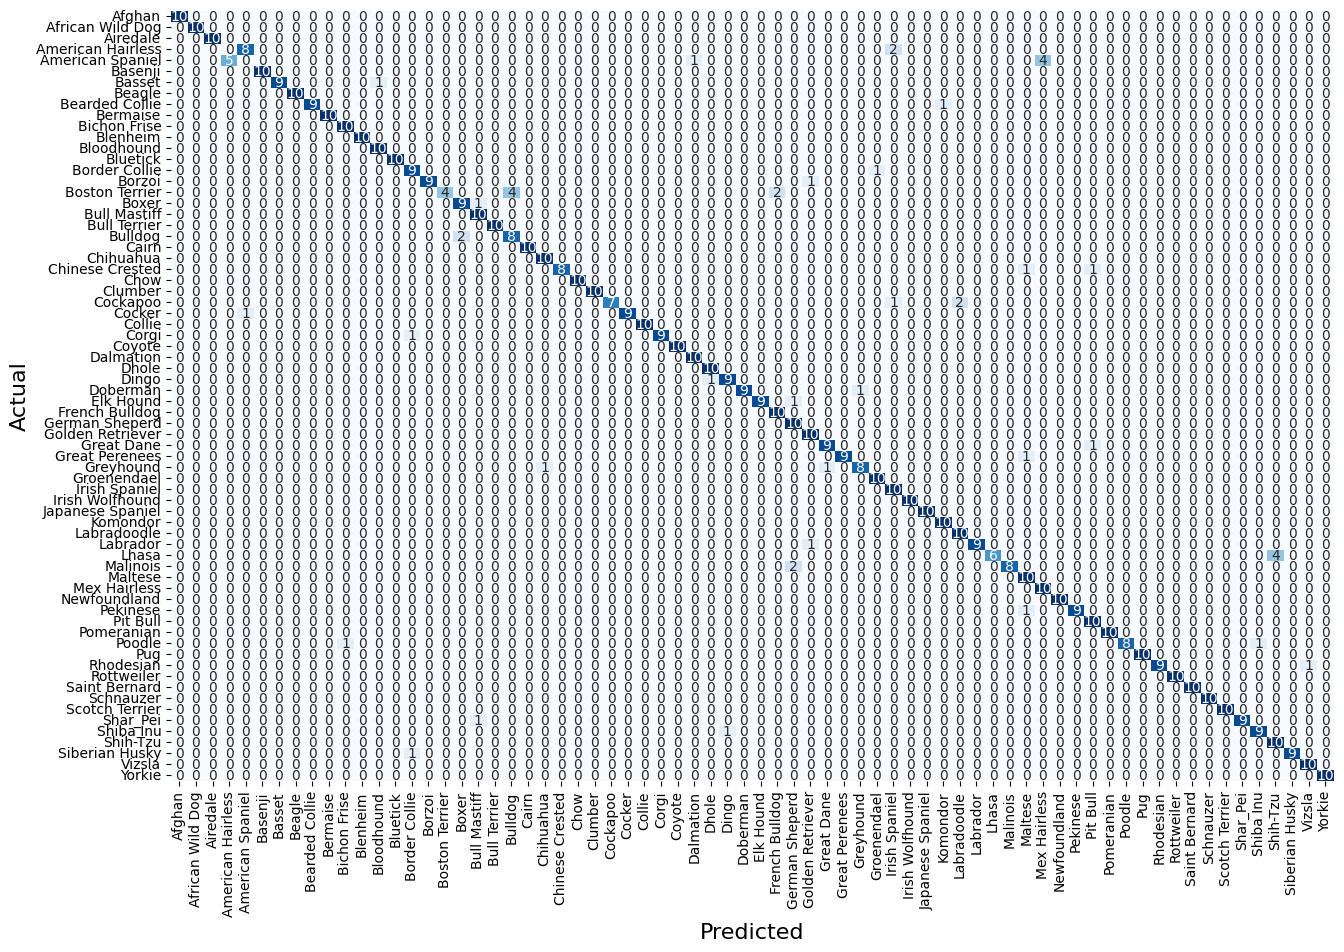

In [165]:
plt.figure(figsize=(15, 10))
sns.heatmap(cm, 
            cmap="Blues", 
            annot=True, 
            fmt="d", 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cbar=False)
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual", fontsize=16)
plt.show()

In [175]:
clf_dict = classification_report(val_labels, model_preds, output_dict=True)
clf_dict

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0},
 '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0},
 '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0},
 '6': {'precision': 1.0,
  'recall': 0.9,
  'f1-score': 0.9473684210526316,
  'support': 10.0},
 '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0},
 '8': {'precision': 1.0,
  'recall': 0.9,
  'f1-score': 0.9473684210526316,
  'support': 10.0},
 '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0},
 '10': {'precision': 0.9090909090909091,
  'recall': 1.0,
  'f1-score': 0.9523809523809523,
  'support': 10.0},
 '11': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0},
 '12': {'precision':

In [138]:
def plot_random_preds(img, pred_probs, labels, sample=5):
    plt.figure(figsize=(sample*4, sample*12))
    for i in range(sample):
        random_num = random.randint(0, len(img)-1)
        random_img = img[random_num]
        random_pred_prob = pred_probs[random_num]
        random_pred_class = class_names[tf.argmax(random_pred_prob)]
        random_true_label = labels[random_num]
        random_true_class = class_names[random_true_label]

        random_top_10_conf_idx = random_pred_prob.argsort()[-10:][::-1]
        random_top_10_conf_values = random_pred_prob[random_top_10_conf_idx]
        random_top_10_conf_class = class_names[random_top_10_conf_idx]

        if random_pred_class == random_true_class:
            color = "green"
        else:
            color = "red"

        plt.subplot(sample, 2, 2*i+1)
        plt.imshow(random_img/255.)
        plt.title(f"Actual: {random_true_class} Predicted: {random_pred_class} Conf: {np.round(random_pred_prob[tf.argmax(random_pred_prob)]*100, decimals=2)}%",
                  color=color)
        plt.axis(False)
        plt.subplot(sample, 2, 2*i+2)
        top_10_plt = plt.bar(np.arange(len(random_top_10_conf_class)),
                             random_top_10_conf_values,
                             color="grey")
        plt.xticks(np.arange(len(random_top_10_conf_class)),
                   labels=random_top_10_conf_class,
                   rotation="vertical")
        
        for idx, value in enumerate(random_top_10_conf_values):
            plt.text(idx, value + 0.01, f"{np.round(value*100, decimals=2)}%", ha='center', va='bottom')

        if np.isin(random_true_class, random_top_10_conf_class):
            top_10_plt[np.argmax(random_top_10_conf_class == random_true_class)].set_color("green")
        else:
            pass

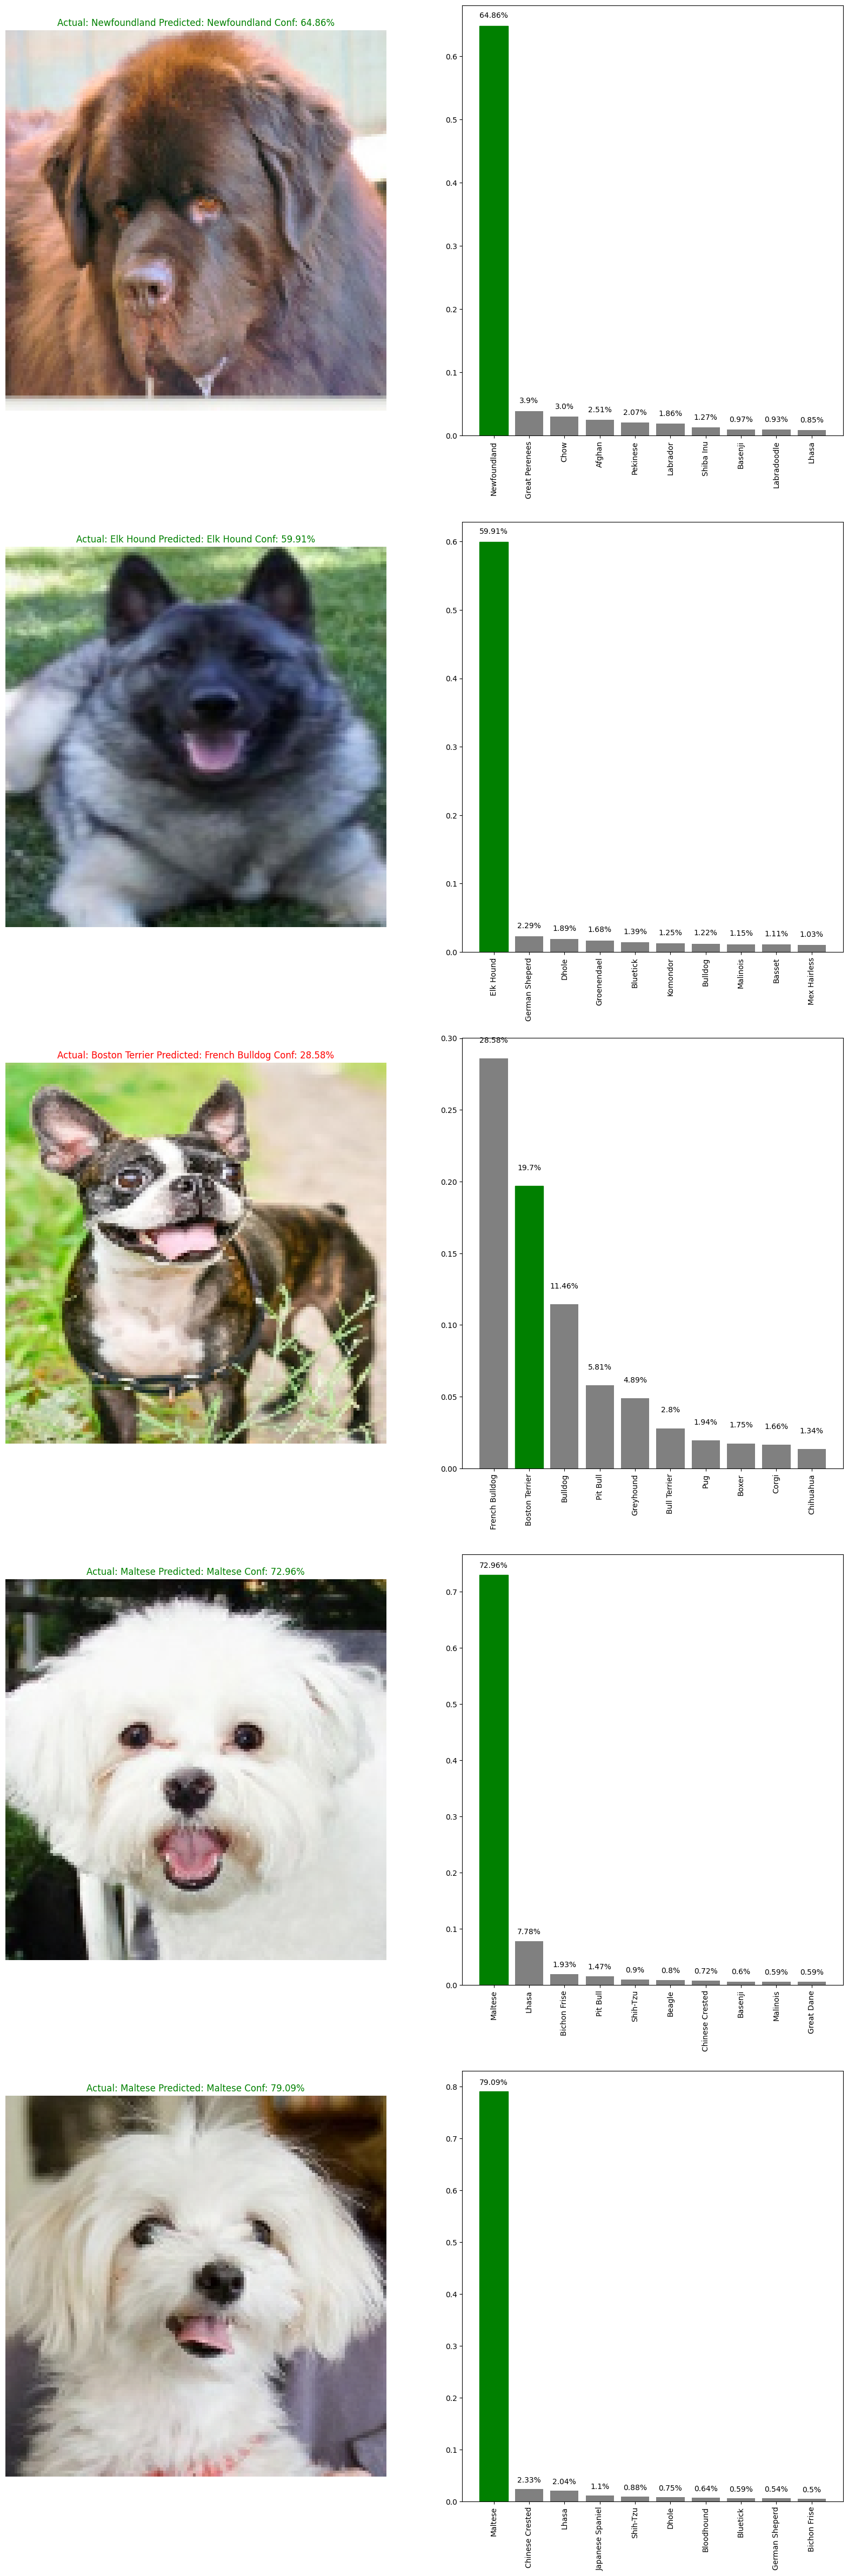

In [167]:
plot_random_preds(val_img, model_preds_probs, val_labels, sample=5)

# Experiment 2 - Transfer Learning Fine-Tuning

In [168]:
tf.keras.backend.clear_session()

base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

In [169]:
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv Fal

In [170]:
model.set_weights(feature_vector)

In [171]:
model.summary()

Model: "b1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 img_augmentation_layer (Seq  (None, 128, 128, 3)      0         
 uential)                                                        
                                                                 
 efficientnetb1 (Functional)  (None, 4, 4, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 70)                89670     
                                                                 
Total params: 6,664,909
Trainable params: 1,426,070
Non-tr

In [172]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

model_history_2 = model.fit(train_dataset,
                            validation_data=val_dataset,
                            epochs=30,
                            callbacks=[tensorboard_cb(LOGS_PATH, model.name + "_ft"),
                                       checkpoint_cb(CHECKPOINT_PATH, model.name + "_ft", save_format=SAVE_FORMAT),
                                       reduce_lr_cb(3, 0.1),
                                       early_stopping_cb(5)])

Epoch 1/30
249/249 [==============================] - ETA: 0s - loss: 2.1263 - accuracy: 0.7459
Epoch 1: val_loss improved from inf to 1.77171, saving model to h5_models\b1_model_ft.h5
249/249 [==============================] - 31s 88ms/step - loss: 2.1263 - accuracy: 0.7459 - val_loss: 1.7717 - val_accuracy: 0.9186 - lr: 1.0000e-04
Epoch 2/30
248/249 [============================>.] - ETA: 0s - loss: 2.0883 - accuracy: 0.7543
Epoch 2: val_loss did not improve from 1.77171
249/249 [==============================] - 20s 79ms/step - loss: 2.0882 - accuracy: 0.7545 - val_loss: 1.7727 - val_accuracy: 0.9086 - lr: 1.0000e-04
Epoch 3/30
248/249 [============================>.] - ETA: 0s - loss: 2.0465 - accuracy: 0.7794
Epoch 3: val_loss did not improve from 1.77171
249/249 [==============================] - 20s 82ms/step - loss: 2.0472 - accuracy: 0.7793 - val_loss: 1.7719 - val_accuracy: 0.9171 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - ETA: 0s - loss: 2.0582 - 

In [173]:
model_loaded = tf.keras.models.load_model(CHECKPOINT_PATH + model.name + "_ft.h5")

In [174]:
model_loaded.evaluate(train_dataset), model_loaded.evaluate(val_dataset)

22/22 [==============================] - 2s 74ms/step - loss: 1.7445 - accuracy: 0.9143


([1.6171867847442627, 0.9366977214813232],
 [1.7444615364074707, 0.9142857193946838])

In [176]:
%load_ext tensorboard
%tensorboard --logdir model_logs --port 8081